In [ ]:
%pip install mesa numpy pandas scipy matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/unicornhappy/.pyenv/versions/3.12.4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


t=200  bb=102.30  ba=103.00  sp=0.700  db=4.00  da=7.00  trades_step=19
t=200  bb=102.40  ba=102.80  sp=0.400  db=59.00  da=51.00  trades_step=2
t=200  bb=109.20  ba=109.40  sp=0.200  db=30.00  da=2.00  trades_step=1
t=200  bb=98.00  ba=98.40  sp=0.400  db=56.00  da=56.00  trades_step=0
t=200  bb=101.70  ba=102.00  sp=0.300  db=15.00  da=21.00  trades_step=31
t=200  bb=105.60  ba=105.90  sp=0.300  db=15.00  da=44.00  trades_step=25
t=200  bb=98.70  ba=99.10  sp=0.400  db=60.00  da=59.00  trades_step=19
t=200  bb=87.80  ba=88.10  sp=0.300  db=20.00  da=14.00  trades_step=21
t=200  bb=98.60  ba=99.30  sp=0.700  db=6.00  da=4.00  trades_step=18
t=200  bb=113.80  ba=114.50  sp=0.700  db=7.00  da=4.00  trades_step=18
t=200  bb=100.80  ba=101.60  sp=0.800  db=6.00  da=20.00  trades_step=17
t=200  bb=95.90  ba=96.30  sp=0.400  db=60.00  da=60.00  trades_step=21
t=200  bb=98.20  ba=98.60  sp=0.400  db=59.00  da=60.00  trades_step=1
t=200  bb=106.40  ba=106.80  sp=0.400  db=59.00  da=58.00  tra

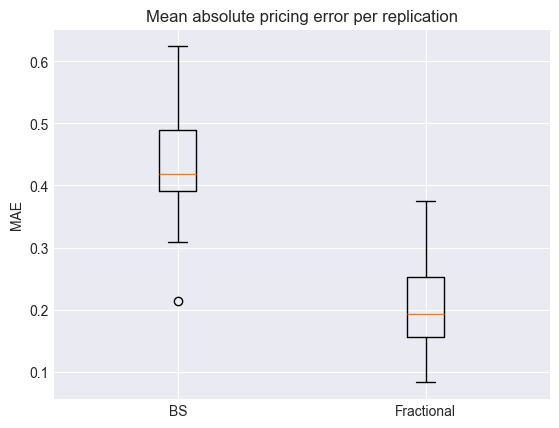

{'option_type': 'put',
 'alpha_frac': 0.5,
 'mean_abs_err_bs': 0.4233602362294035,
 'mean_abs_err_frac': 0.20474419688107517,
 'paired_ttest_t': 15.375432515627413,
 'paired_ttest_p': 9.099653987542558e-08,
 'wilcoxon_stat': 0.0,
 'wilcoxon_p': 0.001953125,
 'ks_stat': 0.4,
 'ks_p': 0.0005822568814776493,
 'n_rep': 10,
 'n_paths': 200,
 'n_mc': 40000}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from analysis import run_h1_pricing_experiment
from visualization import plot_error_box
from analysis import run_abm_paths, estimate_sigma
from model import ABMModel 
plt.style.use('seaborn-v0_8-darkgrid')


cfg = dict(
    S0=100.0,
    dt=1/252,
    steps=252,
    n_fund=50,
    n_noise=50,
    n_chart=50,
    n_mm=4,
    fundamental_price=100.0,
    tick_size=0.1,
    impact=0.07,
    omega=1e-6,
    alpha_var=0.05,
    beta_var=0.94,
    fund_strength=0.1,
    chart_strength=0.6,
    chart_vol_sens=2.0,
    mom_window=20,
    vol_window=20,
    agent_noise=0.15,
    p01=0.02,
    p10=0.10,
    shock_rate=0.01,
    shock_impact=8.0,
    n_events_calm=400,
    n_events_stress=1200,
)

dt = cfg["dt"]
steps = cfg["steps"]
r = 0.0

K_grid = [70, 80, 90, 95, 100]

paths = run_abm_paths(cfg, n_paths=50, seed0=1)
print("zero-return share:", (np.diff(paths, axis=1) == 0).mean())
print("min moves per path:", np.min(np.sum(np.diff(paths, axis=1) != 0, axis=1)))


df, by_rep, summary = run_h1_pricing_experiment(
    cfg=cfg,
    dt=dt,
    steps=steps,
    r=r,
    K_grid=K_grid,
    option_type="put",
    alpha_frac=0.5,
    n_paths=200,
    n_mc=40000,
    n_rep=10,
    seed0=0
)

plot_error_box(by_rep)
summary


In [ ]:
cfg_dbg = dict(cfg)
cfg_dbg.update(dict(
    debug=True,
    debug_print_every=0,
    debug_snapshot_every=25,
    debug_l2_depth=10,
    max_events=3000,
))

m = ABMModel(seed=0, **cfg_dbg)
prices = m.run()

df = pd.DataFrame({
    "t": np.arange(len(m.regime_log)),
    "price": np.array(m.market.prices[1:], dtype=float),
    "ret": np.array(m.market.log_returns, dtype=float),
    "regime": np.array(m.regime_log, dtype=int),
    "spread": np.array(m.spread_log, dtype=float),
    "depth_bid": np.array(m.depth_bid_log, dtype=float),
    "depth_ask": np.array(m.depth_ask_log, dtype=float),
    "imb": np.array(m.imbalance_log, dtype=float),
    "trades": np.array(m.trade_count_log, dtype=int),
    "vol": np.array(m.volume_log, dtype=float),
    "n_events": np.array(m.n_events_log, dtype=int),
    "Lambda_reg": np.array(m.lambda_reg_log, dtype=float),
    "cap_hit": np.array(m.hawkes_cap_hit_log, dtype=int),
    "bb_none": np.array(m.bb_none_log, dtype=int),
    "ba_none": np.array(m.ba_none_log, dtype=int),
    "orders": np.array(m.order_count_log, dtype=int),
    "bid_lvls": np.array(m.bid_levels_log, dtype=int),
    "ask_lvls": np.array(m.ask_levels_log, dtype=int),
    "crossed": np.array(m.crossed_log, dtype=int),
    "n_limit": np.array(m.n_limit_log, dtype=int),
    "n_market": np.array(m.n_market_log, dtype=int),
    "n_cancel": np.array(m.n_cancel_log, dtype=int),
    "n_expire": np.array(m.n_expire_log, dtype=int),
    "mm_requote": np.array(m.mm_requotes_log, dtype=int),
    "meta_active": np.array(m.meta_active_log, dtype=int),
    "meta_left": np.array(m.meta_left_log, dtype=int),
    "meta_intensity": np.array(m.meta_intensity_log, dtype=int),
    "meta_side": np.array(m.meta_side_log, dtype=int),
})

df.head(20)
# df.info()


t=200  bb=90.80  ba=91.10  sp=0.300  db=59.00  da=8.00  trades_step=1


,t,price,ret,regime,spread,depth_bid,depth_ask,imb,trades,vol,...,crossed,n_limit,n_market,n_cancel,n_expire,mm_requote,meta_active,meta_left,meta_intensity,meta_side
0,0,99.8,0.000000,0,0.4,59.0,60.0,-0.008403,1,1.0,...,0,40,1,0,0,4,0,0,0,-1
1,1,100.2,0.000000,0,0.4,59.0,59.0,0.000000,1,1.0,...,0,0,1,0,0,0,0,0,0,-1
2,2,99.8,0.000000,1,0.4,55.0,58.0,-0.026549,5,5.0,...,0,0,5,0,0,0,0,0,0,-1
3,3,100.1,0.000000,1,0.4,52.0,58.0,-0.054545,3,4.0,...,0,1,3,0,0,0,0,0,0,-1
4,4,99.8,0.000000,1,0.4,45.0,45.0,0.000000,2,2.0,...,0,0,2,0,6,0,0,0,0,-1
5,5,99.8,0.000000,1,0.4,44.0,45.0,-0.011236,1,1.0,...,0,0,1,0,4,0,0,0,0,-1
6,6,100.2,0.000000,1,0.4,44.0,44.0,0.000000,1,1.0,...,0,2,1,0,2,1,0,0,0,-1
7,7,99.8,0.000000,1,0.4,28.0,29.0,-0.017544,1,1.0,...,0,0,1,0,12,0,0,0,0,-1
8,8,100.2,0.000000,1,0.4,13.0,13.0,0.000000,1,1.0,...,0,6,1,0,8,2,0,0,0,-1
9,9,100.5,0.000000,1,1.0,14.0,14.0,0.000000,1,1.0,...,0,10,1,2,8,3,0,0,0,-1


In [ ]:
zero_ret = float((df["ret"] == 0).mean())
bb_missing = float(df["bb_none"].mean())
ba_missing = float(df["ba_none"].mean())
crossed = int(df["crossed"].sum())
cap_share = float(df["cap_hit"].mean())

print("zero-return share:", zero_ret)
print("bb missing share:", bb_missing, "ba missing share:", ba_missing)
print("crossed count:", crossed)
print("hawkes cap-hit share:", cap_share)

print("avg events:", float(df["n_events"].mean()), "max events:", int(df["n_events"].max()))
print("avg spread:", float(df["spread"].mean()), "min spread:", float(df["spread"].min()))
print("avg trades/step:", float(df["trades"].mean()), "avg vol/step:", float(df["vol"].mean()))
print("avg limits/mkt/cancel:", float(df["n_limit"].mean()), float(df["n_market"].mean()), float(df["n_cancel"].mean()))
print("mm requote rate:", float(df["mm_requote"].mean()))


zero-return share: 0.8849206349206349
bb missing share: 0.0 ba missing share: 0.0
crossed count: 0
hawkes cap-hit share: 0.0
avg events: 1.9365079365079365 max events: 7
avg spread: 0.45277777777777667 min spread: 0.10000000000000853
avg trades/step: 6.23015873015873 avg vol/step: 22.21825396825397
avg limits/mkt/cancel: 9.734126984126984 4.484126984126984 2.2976190476190474
mm requote rate: 2.761904761904762


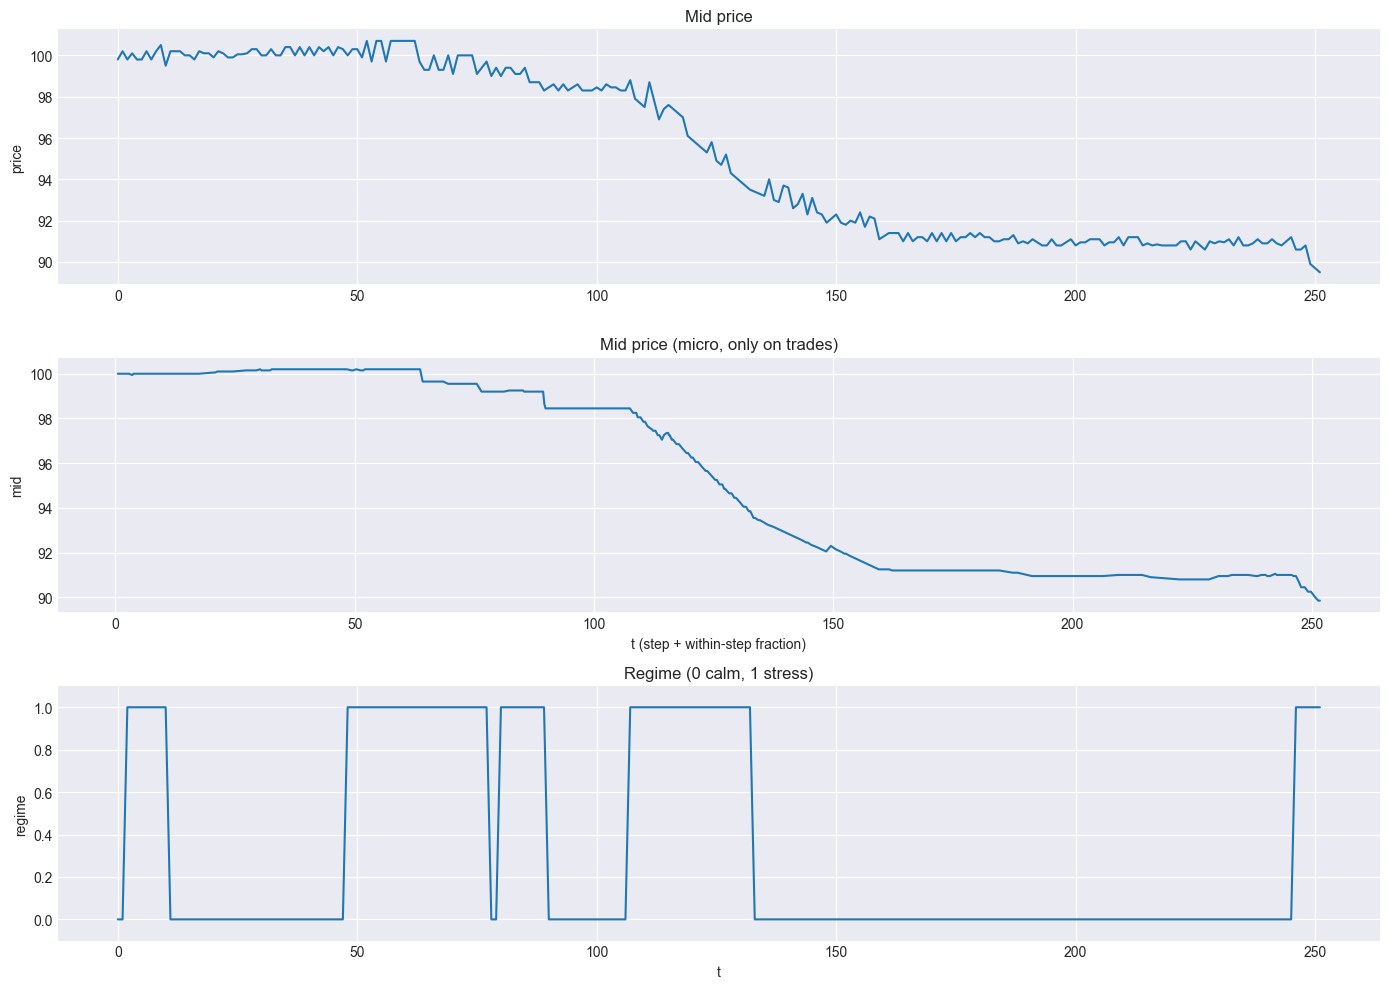

In [ ]:
t_micro = np.array([x for x, _ in m.mid_micro_log], dtype=float)
mid_micro = np.array([y for _, y in m.mid_micro_log], dtype=float)

fig, axs = plt.subplots(3, 1, sharex=False, figsize=(14, 10))

axs[0].plot(df["t"], df["price"])
axs[0].set_title("Mid price")
axs[0].set_ylabel("price")

axs[1].plot(t_micro, mid_micro)
axs[1].set_title("Mid price (micro, only on trades)")
axs[1].set_xlabel("t (step + within-step fraction)")
axs[1].set_ylabel("mid")


axs[2].plot(df["t"], df["regime"])
axs[2].set_title("Regime (0 calm, 1 stress)")
axs[2].set_xlabel("t")
axs[2].set_ylabel("regime")
axs[2].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

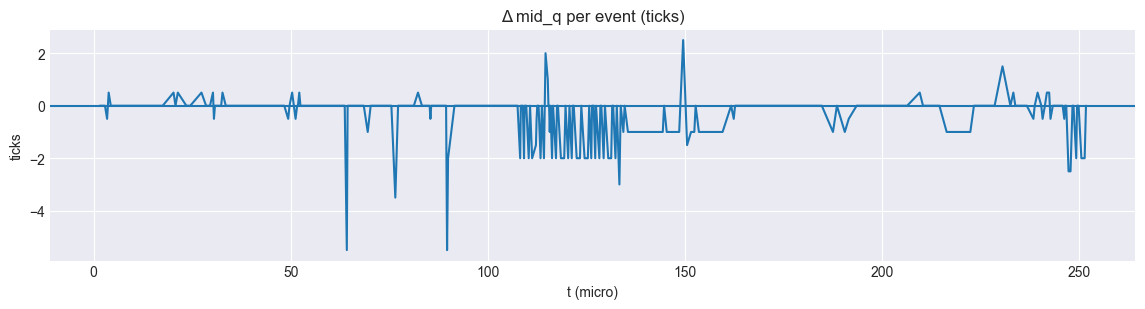

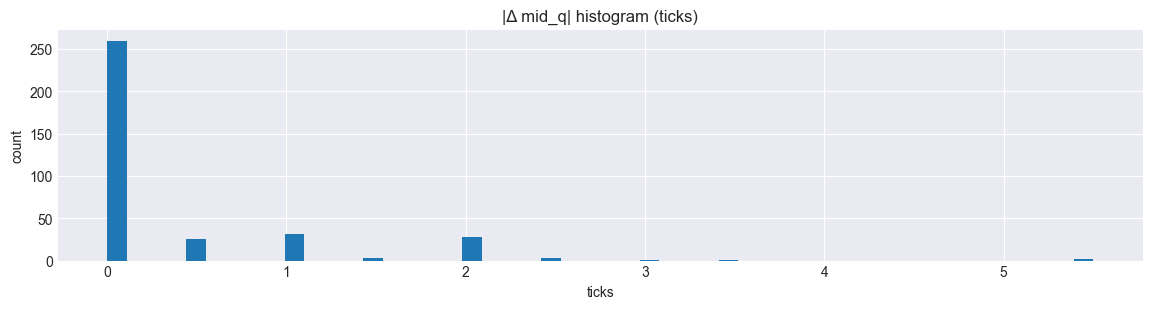

In [ ]:
d_mid_ticks = np.diff(mid_micro) / m.tick_size

plt.figure(figsize=(14,3))
plt.plot(t_micro[1:], d_mid_ticks)
plt.title("Δ mid_q per event (ticks)")
plt.xlabel("t (micro)")
plt.ylabel("ticks")
plt.axhline(0.0)
plt.show()

plt.figure(figsize=(14,3))
plt.hist(np.abs(d_mid_ticks), bins=50)
plt.title("|Δ mid_q| histogram (ticks)")
plt.xlabel("ticks")
plt.ylabel("count")
plt.show()


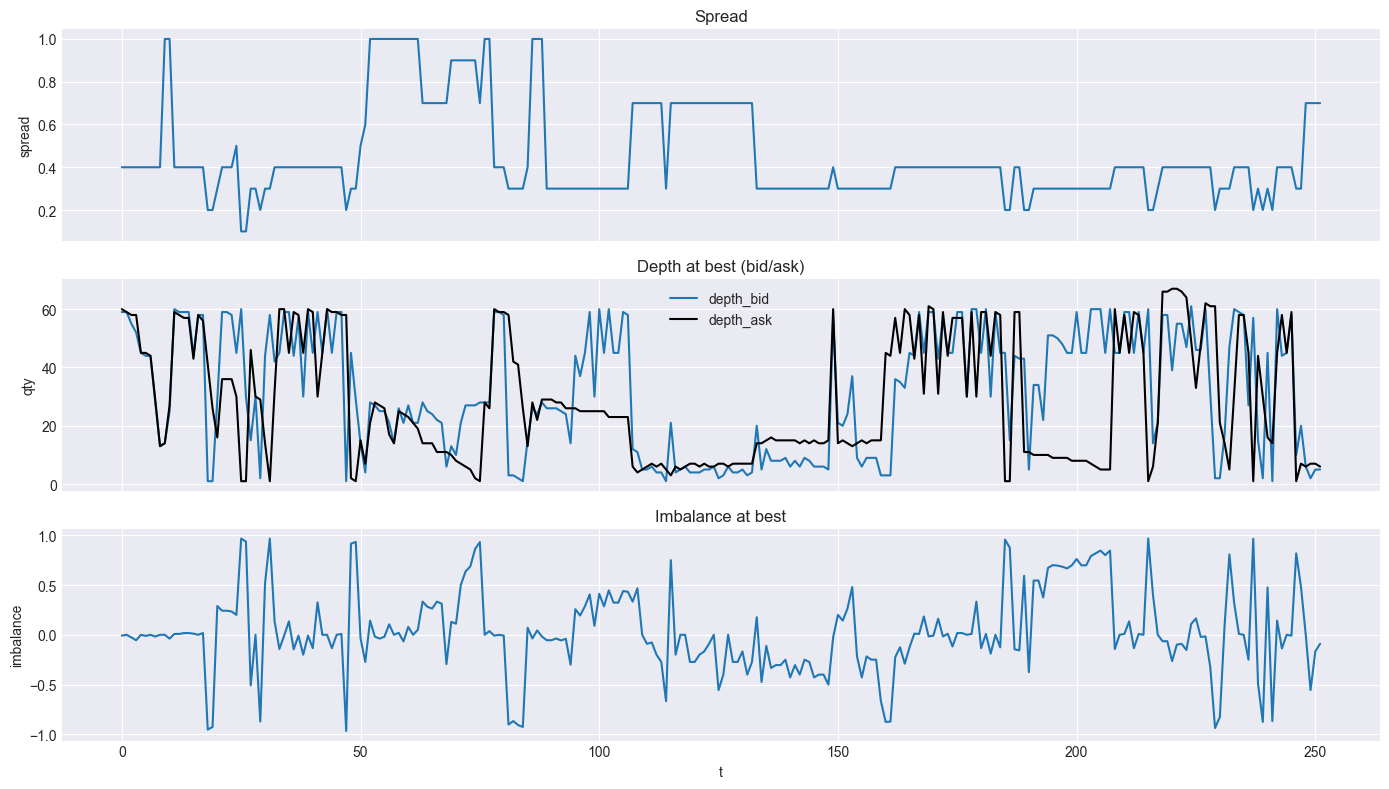

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(14, 8))

axs[0].plot(df["t"], df["spread"])
axs[0].set_title("Spread")
axs[0].set_ylabel("spread")

axs[1].plot(df["t"], df["depth_bid"], label="depth_bid")
axs[1].plot(df["t"], df["depth_ask"], label="depth_ask", color='k')
axs[1].set_title("Depth at best (bid/ask)")
axs[1].set_ylabel("qty")
axs[1].legend()

axs[2].plot(df["t"], df["imb"])
axs[2].set_title("Imbalance at best")
axs[2].set_xlabel("t")
axs[2].set_ylabel("imbalance")

plt.tight_layout()
plt.show()

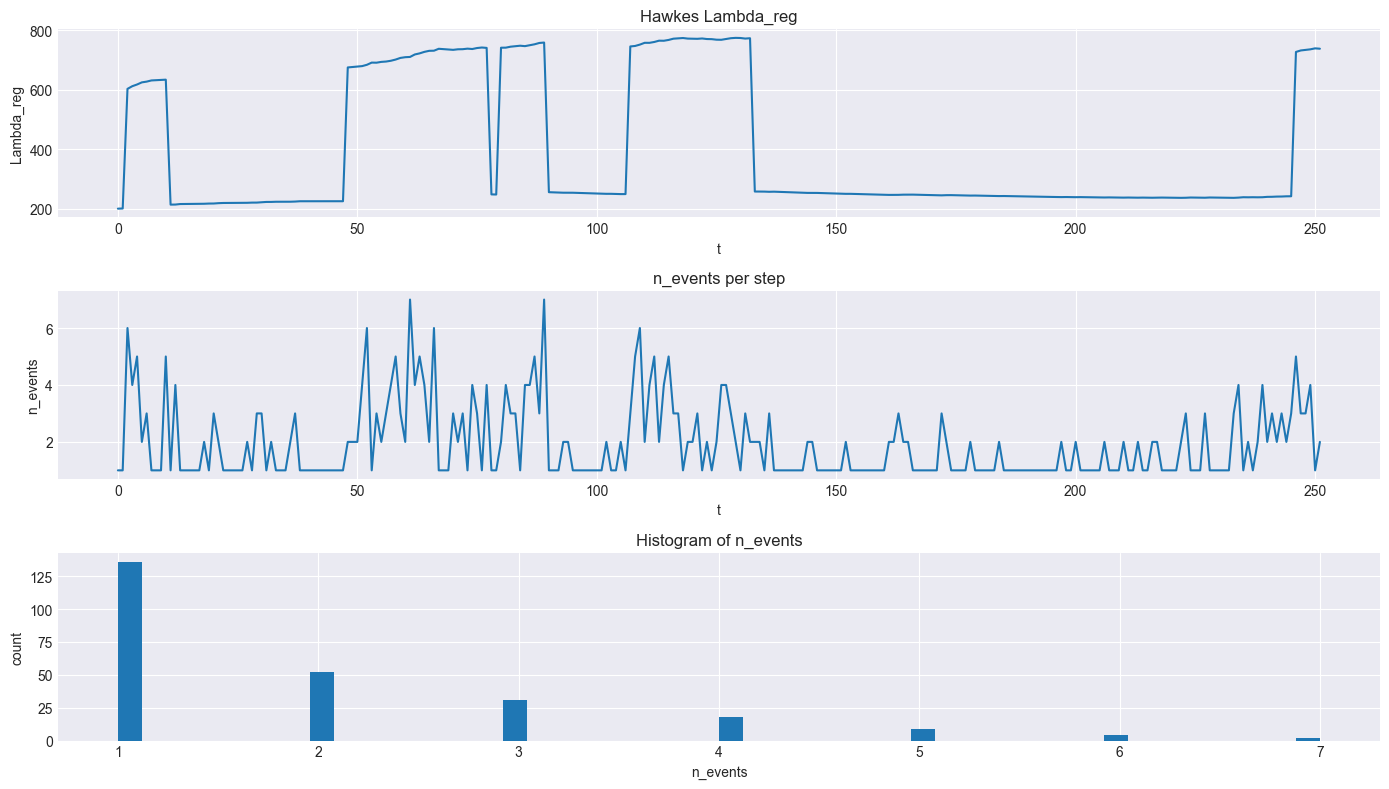

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(14, 8))

axs[0].plot(df["t"], df["Lambda_reg"])
axs[0].set_title("Hawkes Lambda_reg")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Lambda_reg")

axs[1].plot(df["t"], df["n_events"])
axs[1].set_title("n_events per step")
axs[1].set_xlabel("t")
axs[1].set_ylabel("n_events")

axs[2].hist(df["n_events"].values, bins=50)
axs[2].set_title("Histogram of n_events")
axs[2].set_xlabel("n_events")
axs[2].set_ylabel("count")

plt.tight_layout()
plt.show()


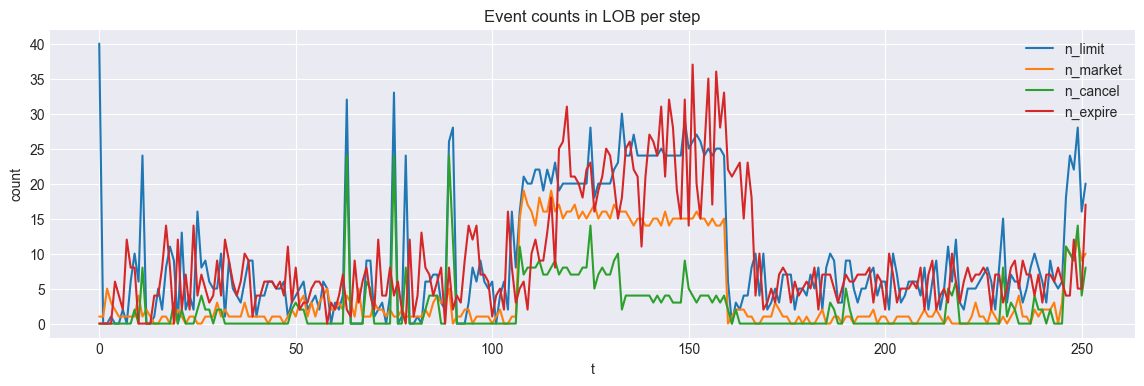

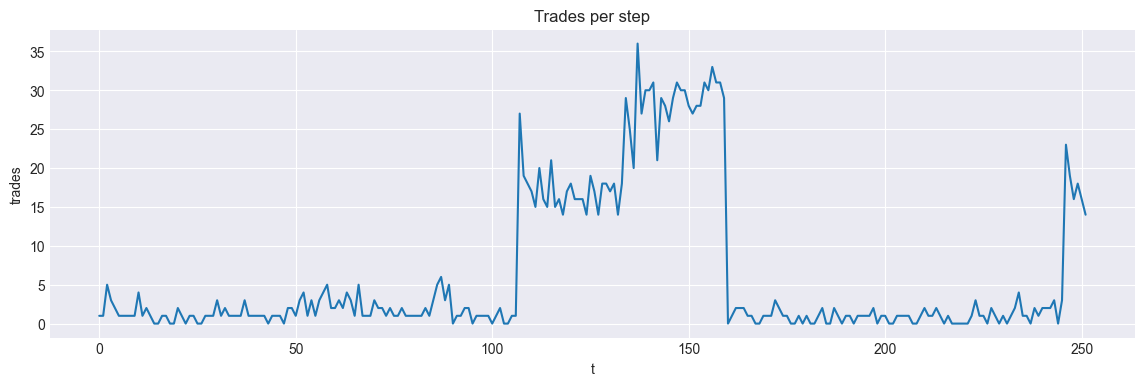

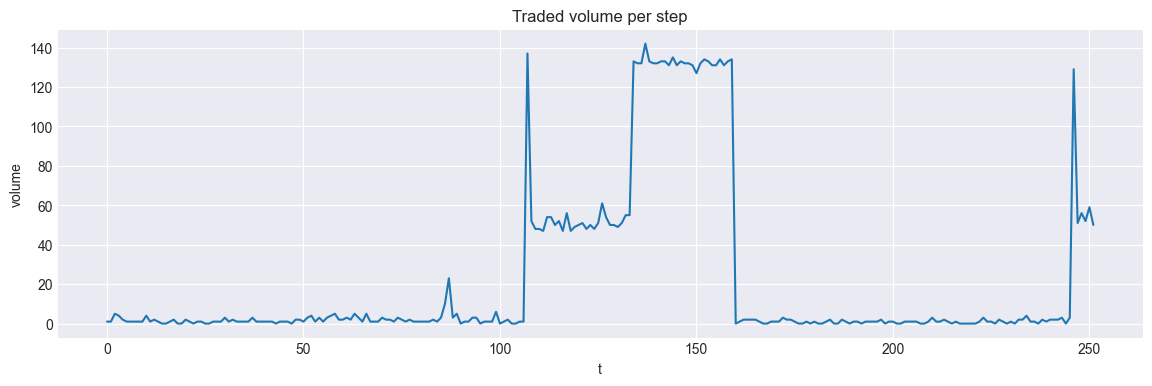

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df["t"], df["n_limit"], label="n_limit")
plt.plot(df["t"], df["n_market"], label="n_market")
plt.plot(df["t"], df["n_cancel"], label="n_cancel")
plt.plot(df["t"], df["n_expire"], label="n_expire")
plt.title("Event counts in LOB per step")
plt.xlabel("t")
plt.ylabel("count")
plt.legend()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df["t"], df["trades"])
plt.title("Trades per step")
plt.xlabel("t")
plt.ylabel("trades")
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df["t"], df["vol"])
plt.title("Traded volume per step")
plt.xlabel("t")
plt.ylabel("volume")
plt.show()


In [ ]:
def show_snapshot(i):
    t, mid, bids, asks = m.l2_snapshots[i]
    print("snapshot", i, "t", t, "mid", mid)
    print("BIDS (ticks, qty):", bids)
    print("ASKS (ticks, qty):", asks)

len(m.l2_snapshots), m.l2_snapshots[0][0] if m.l2_snapshots else None
show_snapshot(0)
show_snapshot(1)
show_snapshot(2)


snapshot 0 t 25 mid 99.9
BIDS (ticks, qty): [(999, 45.0), (998, 21.0), (997, 5.0), (996, 12.0), (995, 6.0)]
ASKS (ticks, qty): [(1004, 30.0), (1005, 10.0), (1006, 12.0), (1007, 12.0)]
snapshot 1 t 50 mid 100.30000000000001
BIDS (ticks, qty): [(1000, 29.0), (999, 21.0), (998, 10.0), (997, 13.0), (996, 12.0), (995, 2.0)]
ASKS (ticks, qty): [(1003, 1.0), (1004, 15.0), (1005, 14.0), (1007, 9.0), (1008, 12.0), (1009, 2.0)]
snapshot 2 t 75 mid 100.0
BIDS (ticks, qty): [(991, 27.0), (990, 3.0), (989, 8.0)]
ASKS (ticks, qty): [(1000, 2.0), (1001, 21.0), (1002, 3.0), (1003, 8.0)]


t=200  bb=102.30  ba=103.00  sp=0.700  db=4.00  da=7.00  trades_step=19
t=200  bb=107.20  ba=107.40  sp=0.200  db=15.00  da=5.00  trades_step=26
t=200  bb=96.60  ba=96.90  sp=0.300  db=7.00  da=15.00  trades_step=16
t=200  bb=100.40  ba=100.80  sp=0.400  db=49.00  da=55.00  trades_step=9
t=200  bb=103.10  ba=103.50  sp=0.400  db=60.00  da=59.00  trades_step=0
t=200  bb=112.70  ba=113.70  sp=1.000  db=11.00  da=25.00  trades_step=6
t=200  bb=97.60  ba=98.60  sp=1.000  db=16.00  da=28.00  trades_step=3
t=200  bb=100.20  ba=100.90  sp=0.700  db=5.00  da=21.00  trades_step=18
t=200  bb=106.20  ba=106.60  sp=0.400  db=60.00  da=61.00  trades_step=23
t=200  bb=97.30  ba=97.60  sp=0.300  db=59.00  da=1.00  trades_step=1
t=200  bb=108.80  ba=109.20  sp=0.400  db=57.00  da=56.00  trades_step=1
t=200  bb=100.90  ba=101.20  sp=0.300  db=15.00  da=9.00  trades_step=26


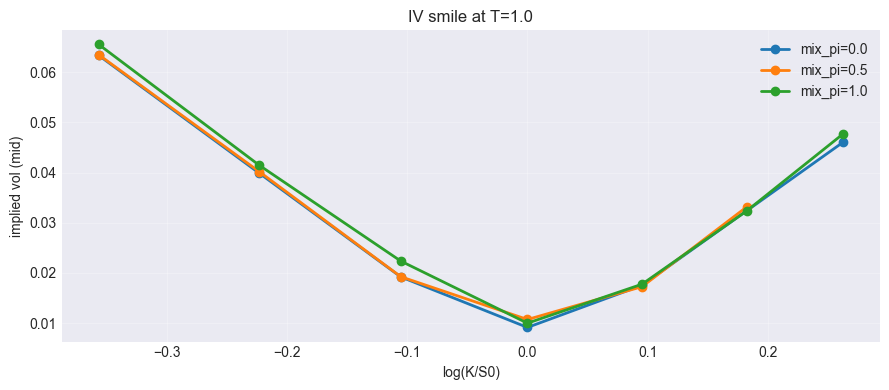

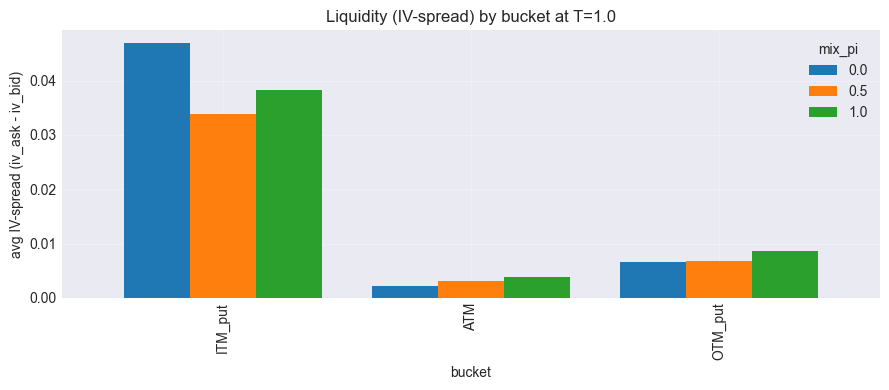

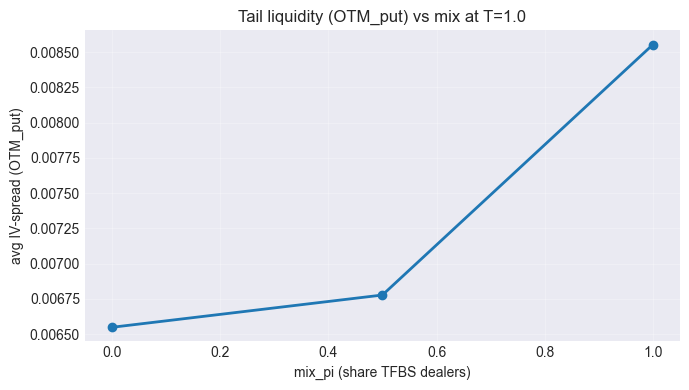

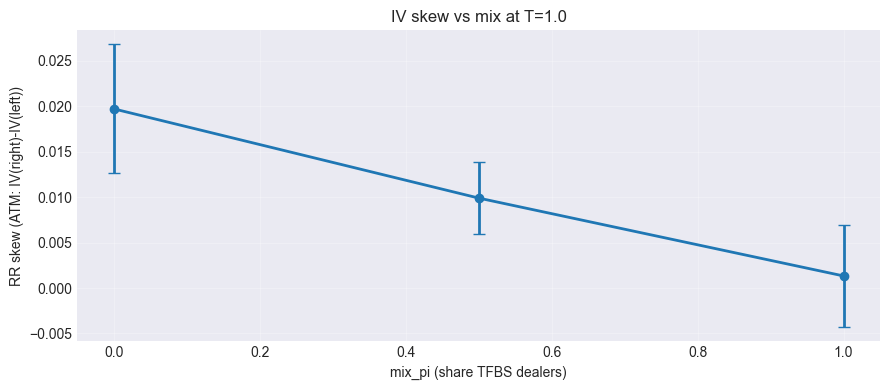

,T,bucket,anova_p_iv_spread_across_mix,anova_p_skew_across_mix
0,0.5,ATM,0.200452,NaN
1,0.5,OTM_put,0.000134,NaN
2,0.5,skew_rr,NaN,0.617568
3,1.0,ATM,0.442382,NaN
4,1.0,OTM_put,0.000580,NaN
5,1.0,skew_rr,NaN,0.121434
6,2.0,ATM,0.019235,NaN
7,2.0,OTM_put,0.000379,NaN
8,2.0,skew_rr,NaN,NaN


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.stats import f_oneway

from model import ABMModel
from market import LimitOrderBook
from analysis import bs_price_call, bs_price_put, fractional_price_call_mc, fractional_price_put_mc


def implied_vol_bs(price, S0, K, r, T, option_type):
    price = float(price); S0 = float(S0); K = float(K); r = float(r); T = float(T)
    if T <= 0 or S0 <= 0 or K <= 0 or not np.isfinite(price):
        return np.nan

    disc = float(np.exp(-r * T))
    if option_type == "call":
        lo = float(max(0.0, S0 - K * disc))
        hi = float(S0)
        f = lambda s: bs_price_call(S0, K, r, s, T) - price
    else:
        lo = float(max(0.0, K * disc - S0))
        hi = float(K * disc)
        f = lambda s: bs_price_put(S0, K, r, s, T) - price

    eps_b = float(1e-12 * max(1.0, hi))
    if price <= lo + eps_b:
        return 0.0
    if price >= hi - eps_b:
        return 5.0

    if price < lo:
        price = float(lo + eps_b)
    if price > hi:
        price = float(hi - eps_b)

    try:
        return float(brentq(f, 1e-6, 5.0, maxiter=200))
    except Exception:
        return np.nan


def bucket_from_m(m, option_type):
    m = float(m)
    if option_type == "put":
        if m < 0.90:
            return "OTM_put"
        if m > 1.10:
            return "ITM_put"
        return "ATM"
    else:
        if m < 0.90:
            return "ITM_call"
        if m > 1.10:
            return "OTM_call"
        return "ATM"


def estimate_sigma_from_model(m_abm, idx, dt, window):
    lr = np.array(m_abm.market.log_returns[:idx], dtype=float)
    lrw = lr[-int(window):] if lr.size > 0 else lr
    s = float(np.std(lrw) / np.sqrt(float(dt))) if lrw.size >= 2 else 0.05
    return float(max(1e-4, s))


def price_model(S0, K, r, sigma, T, option_type, is_tfbs, alpha_frac, n_mc, seed):
    if not is_tfbs:
        if option_type == "put":
            return float(bs_price_put(S0, K, r, sigma, T))
        return float(bs_price_call(S0, K, r, sigma, T))
    if option_type == "put":
        return float(fractional_price_put_mc(S0, K, r, sigma, T, alpha=alpha_frac, n_mc=int(n_mc), seed=int(seed)))
    return float(fractional_price_call_mc(S0, K, r, sigma, T, alpha=alpha_frac, n_mc=int(n_mc), seed=int(seed)))


def build_option_quotes_from_lob(
    S0,
    K,
    r,
    sigma,
    T,
    option_type,
    mix_pi,
    alpha_frac,
    n_mc,
    n_dealers,
    under_spread,
    under_depth,
    rng,
    tick_size=1e-4,
    base_halfspread_frac=0.02,
    k_liq=40.0,
    risk_wings=2.0,
    u_stress=None,
    under_regime=None,
):
    S0 = float(S0); K = float(K); r = float(r); sigma = float(sigma); T = float(T)
    mix_pi = float(mix_pi)
    under_spread = float(under_spread) if np.isfinite(under_spread) else 0.0
    under_depth = float(under_depth) if np.isfinite(under_depth) else 1.0
    under_depth = float(max(1.0, under_depth))

    if u_stress is None or not np.isfinite(float(u_stress)):
        u_stress = float(rng.uniform())
    else:
        u_stress = float(u_stress)

    if under_regime is None or not np.isfinite(float(under_regime)):
        under_regime = 0.0
    else:
        under_regime = float(under_regime)

    book = LimitOrderBook(tick_size=float(tick_size), rng=rng)

    n_tfbs = int(round(mix_pi * int(n_dealers)))
    is_tfbs_flags = np.array([1] * n_tfbs + [0] * (int(n_dealers) - n_tfbs), dtype=int)
    rng.shuffle(is_tfbs_flags)

    logm = float(np.log(max(1e-12, K / S0)))
    neg = float(max(-logm, 0.0))
    pos = float(max(logm, 0.0))
    if option_type == "put":
        wing_mult = float(1.0 + risk_wings * (1.8 * neg + 0.6 * pos))
        tail = float(neg)
    else:
        wing_mult = float(1.0 + risk_wings * (1.8 * pos + 0.6 * neg))
        tail = float(pos)

    liq = float((under_spread / max(S0, 1e-12)) * (1.0 + 5.0 / np.sqrt(under_depth)))
    liq_mult = float(1.0 + k_liq * liq)

    p_stress = (
        0.03
        + 0.55 * under_regime
        + 0.55 * mix_pi * (tail / (tail + 0.12))
        + 0.20 * (liq / (liq + 0.002))
    )
    p_stress = float(min(0.97, max(0.01, p_stress)))
    opt_regime = 1 if u_stress < p_stress else 0

    seed_tf = int(rng.integers(1, 2_000_000_000))
    seed_rn = int(rng.integers(1, 2_000_000_000))
    fv_rn = price_model(S0, K, r, sigma, T, option_type, False, alpha_frac, n_mc, seed_rn)
    fv_tf = price_model(S0, K, r, sigma, T, option_type, True,  alpha_frac, n_mc, seed_tf)

    disc = float(np.exp(-r * T))
    if option_type == "put":
        intrinsic = float(max(K * disc - S0, 0.0))
        eps_u = float(1e-12 * max(1.0, K * disc))
        upper = float(K * disc - eps_u)
    else:
        intrinsic = float(max(S0 - K * disc, 0.0))
        eps_u = float(1e-12 * max(1.0, S0))
        upper = float(S0 - eps_u)

    base_q = int(max(1, 5 // (1 + int(2 * abs(logm)))))

    bids_all = []
    asks_all = []

    for j in range(int(n_dealers)):
        is_tfbs = bool(is_tfbs_flags[j] == 1)

        fv = float(fv_tf if is_tfbs else fv_rn)
        fv = float(fv * (1.0 + 0.003 * float(rng.normal())))
        fv = float(max(fv, intrinsic + 1e-10))
        fv = float(min(fv, upper))

        extr = float(max(fv - intrinsic, 1e-10))

        half = float(base_halfspread_frac * wing_mult * liq_mult * extr)
        half = float(max(1e-8, half))

        q = int(base_q)

        if opt_regime == 1:
            half = float(half * (1.0 + 2.0 * tail + 0.7))
            q = int(max(1, round(q * 0.55)))

        if is_tfbs:
            half = float(half * (1.0 + 3.0 * tail + 1.0 * opt_regime))
            q = int(max(1, round(q * 0.55 / (1.0 + 4.5 * tail))))

        bid = float(intrinsic + max(1e-10, extr - half))
        ask = float(intrinsic + (extr + half))

        bid = float(min(bid, upper - 2e-10))
        ask = float(min(ask, upper))
        if ask <= bid:
            ask = float(min(upper, bid + 1e-10))
        if bid < intrinsic + 1e-10:
            bid = float(intrinsic + 1e-10)
            if ask <= bid:
                ask = float(min(upper, bid + 1e-10))

        bids_all.append(bid)
        asks_all.append(ask)

        book.add_limit(agent_id=j, side="buy", price=bid, qty=q, ttl=10_000)
        book.add_limit(agent_id=j, side="sell", price=ask, qty=q, ttl=10_000)

    bids_all = np.array(bids_all, dtype=float)
    asks_all = np.array(asks_all, dtype=float)

    bid = float(np.quantile(bids_all, 0.70))
    ask = float(np.quantile(asks_all, 0.30))

    if not np.isfinite(bid) or not np.isfinite(ask) or ask <= bid:
        bid = float(np.quantile(bids_all, 0.60))
        ask = float(np.quantile(asks_all, 0.40))

    if not np.isfinite(bid) or not np.isfinite(ask) or ask <= bid:
        bid = float(np.max(bids_all))
        ask = float(np.min(asks_all))

    if not np.isfinite(bid) or not np.isfinite(ask) or ask <= bid:
        return {"bid": np.nan, "ask": np.nan, "mid": np.nan, "spread": np.nan}

    mid = float(0.5 * (bid + ask))
    return {"bid": bid, "ask": ask, "mid": mid, "spread": float(ask - bid)}


def compute_rr_skew_atm(d):
    g = d.groupby("logm")["iv"].mean()
    xs = np.array(sorted(g.index.values), dtype=float)

    left = xs[xs < 0.0]
    right = xs[xs > 0.0]
    if left.size == 0 or right.size == 0:
        return np.nan

    xL = float(left.max())
    xR = float(right.min())
    yL = float(g.loc[xL])
    yR = float(g.loc[xR])
    return float(yR - yL)


def _style_ax(ax):
    ax.grid(True, alpha=0.25)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)


def plot_h4(df, skew, T_pick):
    T_pick = float(T_pick)

    d = df[df["T"] == T_pick].dropna(subset=["iv", "logm"]).copy()
    fig, ax = plt.subplots(figsize=(9, 4))
    for mix_pi in sorted(d["mix_pi"].unique()):
        s = d[d["mix_pi"] == mix_pi].groupby("logm", as_index=False)["iv"].mean().sort_values("logm")
        ax.plot(s["logm"].values, s["iv"].values, marker="o", linewidth=2, label=f"mix_pi={mix_pi}")
    ax.set_xlabel("log(K/S0)")
    ax.set_ylabel("implied vol (mid)")
    ax.set_title(f"IV smile at T={T_pick}")
    ax.legend(frameon=False)
    _style_ax(ax)
    plt.tight_layout()
    plt.show()

    g = df[df["T"] == T_pick].groupby(["mix_pi", "bucket"], as_index=False)["iv_spread"].mean()

    # bar: ITM_put, ATM, OTM_put (for puts, tail is OTM_put)
    piv = g.pivot(index="bucket", columns="mix_pi", values="iv_spread")
    piv = piv.reindex(["ITM_put", "ATM", "OTM_put"])

    fig, ax = plt.subplots(figsize=(9, 4))
    piv.plot(kind="bar", ax=ax, width=0.8)
    ax.set_xlabel("bucket")
    ax.set_ylabel("avg IV-spread (iv_ask - iv_bid)")
    ax.set_title(f"Liquidity (IV-spread) by bucket at T={T_pick}")
    ax.legend(title="mix_pi", frameon=False)
    _style_ax(ax)
    plt.tight_layout()
    plt.show()

    # tail-only plot (focus H4)
    tail = g[g["bucket"] == "OTM_put"].sort_values("mix_pi")
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(tail["mix_pi"].values, tail["iv_spread"].values, marker="o", linewidth=2)
    ax.set_xlabel("mix_pi (share TFBS dealers)")
    ax.set_ylabel("avg IV-spread (OTM_put)")
    ax.set_title(f"Tail liquidity (OTM_put) vs mix at T={T_pick}")
    _style_ax(ax)
    plt.tight_layout()
    plt.show()

    dsk = skew[skew["T"] == T_pick].dropna(subset=["b_skew"]).copy()
    gsk = dsk.groupby("mix_pi")["b_skew"].agg(["mean", "std", "count"]).reset_index()
    sem = gsk["std"].values / np.sqrt(np.maximum(1, gsk["count"].values))

    fig, ax = plt.subplots(figsize=(9, 4))
    ax.errorbar(gsk["mix_pi"].values, gsk["mean"].values, yerr=sem, marker="o", linewidth=2, capsize=4)
    ax.set_xlabel("mix_pi (share TFBS dealers)")
    ax.set_ylabel("RR skew (ATM: IV(right)-IV(left))")
    ax.set_title(f"IV skew vs mix at T={T_pick}")
    _style_ax(ax)
    plt.tight_layout()
    plt.show()


def run_h4_mixed_dealers(
    cfg_base,
    r=0.0,
    option_type="put",
    alpha_frac=0.80,
    T_list=(0.5, 1.0, 2.0),
    moneyness_grid=(0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3),
    mix_list=(0.0, 0.5, 1.0),
    n_rep=12,
    seed0=1,
    window=50,
    n_dealers=25,
    n_mc=20000,
    base_halfspread_frac=0.02,
    k_liq=40.0,
    risk_wings=2.5,
    tick_size_opt=1e-4,
    T_pick=1.0,
):
    cfg_base = dict(cfg_base)
    dt = float(cfg_base["dt"])
    S0 = float(cfg_base["S0"])
    T_list = tuple(float(x) for x in T_list)
    moneyness_grid = tuple(float(x) for x in moneyness_grid)
    mix_list = tuple(float(x) for x in mix_list)

    rows = []
    skew_rows = []

    for rep in range(int(n_rep)):
        seed = int(seed0 + rep * 999)
        rng = np.random.default_rng(seed)

        m_abm = ABMModel(seed=seed, **cfg_base)
        m_abm.run()

        for T in T_list:
            idx = int(round(T / dt))
            idx = max(2, min(idx, len(m_abm.spread_log)))
            a = max(0, idx - int(window))
            b = idx

            under_sp = float(np.nanmean(np.array(m_abm.spread_log[a:b], dtype=float)))
            db = float(np.nanmean(np.array(m_abm.depth_bid_log[a:b], dtype=float)))
            da = float(np.nanmean(np.array(m_abm.depth_ask_log[a:b], dtype=float)))
            under_depth = float(max(1.0, 0.5 * (db + da)))

            under_reg = float(np.nanmean(np.array(m_abm.regime_log[a:b], dtype=float))) if len(m_abm.regime_log) else 0.0
            under_reg = float(min(1.0, max(0.0, under_reg)))

            sigma = float(estimate_sigma_from_model(m_abm, idx, dt, window))

            for m in moneyness_grid:
                u_stress = float(rng.uniform())

                for mix_pi in mix_list:
                    K = float(S0 * float(m))
                    logm = float(np.log(K / S0))
                    buck = bucket_from_m(m, option_type)

                    q = build_option_quotes_from_lob(
                        S0=S0, K=K, r=r, sigma=sigma, T=T,
                        option_type=option_type,
                        mix_pi=mix_pi,
                        alpha_frac=alpha_frac,
                        n_mc=n_mc,
                        n_dealers=n_dealers,
                        under_spread=under_sp,
                        under_depth=under_depth,
                        rng=rng,
                        tick_size=tick_size_opt,
                        base_halfspread_frac=base_halfspread_frac,
                        k_liq=k_liq,
                        risk_wings=risk_wings,
                        u_stress=u_stress,
                        under_regime=under_reg,
                    )

                    bid = float(q["bid"]); ask = float(q["ask"]); mid = float(q["mid"])
                    iv_mid = implied_vol_bs(mid, S0, K, r, T, option_type)
                    iv_bid = implied_vol_bs(bid, S0, K, r, T, option_type)
                    iv_ask = implied_vol_bs(ask, S0, K, r, T, option_type)
                    iv_spread = float(iv_ask - iv_bid) if (np.isfinite(iv_ask) and np.isfinite(iv_bid)) else np.nan

                    rows.append({
                        "rep": int(rep),
                        "T": float(T),
                        "mix_pi": float(mix_pi),
                        "m": float(m),
                        "K": float(K),
                        "logm": float(logm),
                        "bucket": buck,
                        "sigma": float(sigma),
                        "bid": bid,
                        "ask": ask,
                        "mid": mid,
                        "price_spread": float(q["spread"]),
                        "iv": float(iv_mid) if np.isfinite(iv_mid) else np.nan,
                        "iv_spread": float(iv_spread) if np.isfinite(iv_spread) else np.nan,
                    })

    df = pd.DataFrame(rows)

    for rep in sorted(df["rep"].unique()):
        for mix_pi in sorted(df["mix_pi"].unique()):
            for T in sorted(df["T"].unique()):
                d = df[(df["rep"] == rep) & (df["mix_pi"] == mix_pi) & (df["T"] == T)].dropna(subset=["iv", "logm"]).copy()
                b_skew = compute_rr_skew_atm(d)
                skew_rows.append({"rep": int(rep), "mix_pi": float(mix_pi), "T": float(T), "b_skew": b_skew})

    skew = pd.DataFrame(skew_rows)

    plot_h4(df, skew, T_pick=T_pick)

    stats_rows = []
    for T in sorted(df["T"].unique()):
        dT = df[df["T"] == T].copy()
        for buck in sorted(dT["bucket"].unique()):
            if buck == "ITM_put":
                continue
            groups = []
            ok = True
            for mix_pi in sorted(dT["mix_pi"].unique()):
                x = dT[(dT["mix_pi"] == mix_pi) & (dT["bucket"] == buck)]["iv_spread"].dropna().values
                if len(x) < 2:
                    ok = False
                groups.append(x)
            p = float(f_oneway(*groups).pvalue) if ok else np.nan
            stats_rows.append({"T": float(T), "bucket": buck, "anova_p_iv_spread_across_mix": p})

        groups = []
        ok = True
        for mix_pi in sorted(skew["mix_pi"].unique()):
            x = skew[(skew["T"] == T) & (skew["mix_pi"] == mix_pi)]["b_skew"].dropna().values
            if len(x) < 2:
                ok = False
            groups.append(x)
        p_sk = float(f_oneway(*groups).pvalue) if ok else np.nan
        stats_rows.append({"T": float(T), "bucket": "skew_rr", "anova_p_skew_across_mix": p_sk})

    stats = pd.DataFrame(stats_rows)
    return df, skew, stats


# ===== run =====
df_h4, skew_h4, stats_h4 = run_h4_mixed_dealers(
    cfg_base=cfg,
    r=0.0,
    option_type="put",
    alpha_frac=0.80,
    T_list=(0.5, 1.0, 2.0),
    moneyness_grid=(0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3),
    mix_list=(0.0, 0.5, 1.0),
    n_rep=12,
    n_dealers=25,
    n_mc=20000,
    base_halfspread_frac=0.02,
    k_liq=40.0,
    risk_wings=2.5,
    tick_size_opt=1e-4,
    T_pick=1.0,
)

stats_h4


t=200  bb=102.30  ba=103.00  sp=0.700  db=4.00  da=7.00  trades_step=19
t=200  bb=107.20  ba=107.40  sp=0.200  db=15.00  da=5.00  trades_step=26
t=200  bb=96.60  ba=96.90  sp=0.300  db=7.00  da=15.00  trades_step=16
t=200  bb=100.40  ba=100.80  sp=0.400  db=49.00  da=55.00  trades_step=9
t=200  bb=103.10  ba=103.50  sp=0.400  db=60.00  da=59.00  trades_step=0
t=200  bb=112.70  ba=113.70  sp=1.000  db=11.00  da=25.00  trades_step=6
t=200  bb=97.60  ba=98.60  sp=1.000  db=16.00  da=28.00  trades_step=3
t=200  bb=100.20  ba=100.90  sp=0.700  db=5.00  da=21.00  trades_step=18
t=200  bb=106.20  ba=106.60  sp=0.400  db=60.00  da=61.00  trades_step=23
t=200  bb=97.30  ba=97.60  sp=0.300  db=59.00  da=1.00  trades_step=1
t=200  bb=108.80  ba=109.20  sp=0.400  db=57.00  da=56.00  trades_step=1
t=200  bb=100.90  ba=101.20  sp=0.300  db=15.00  da=9.00  trades_step=26


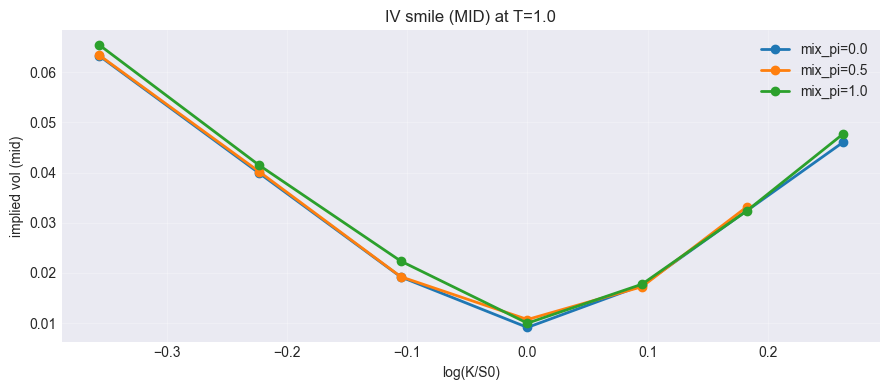

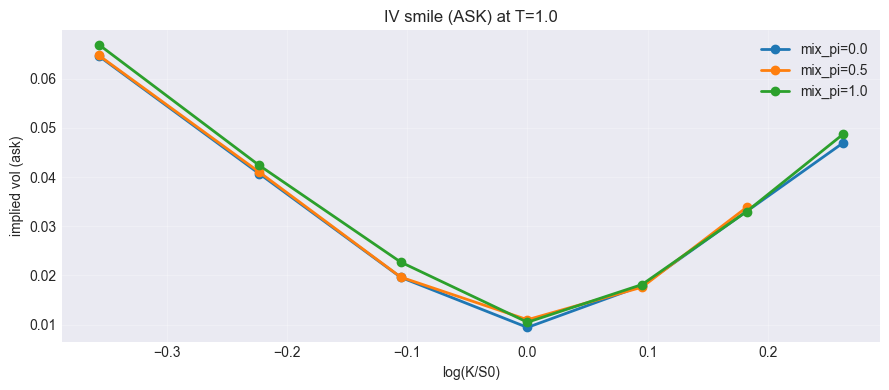

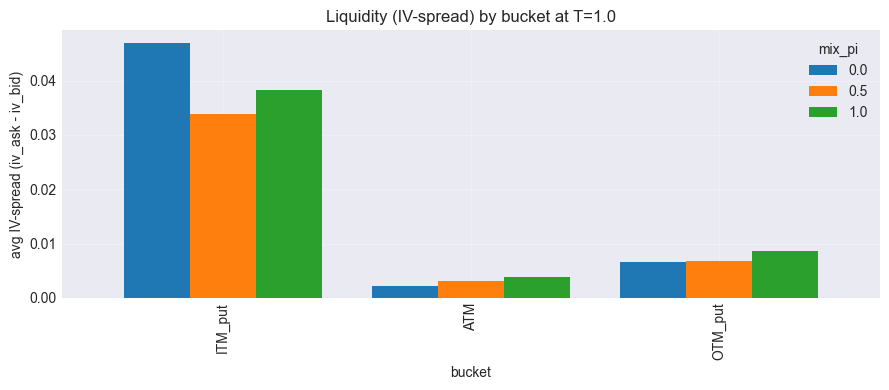

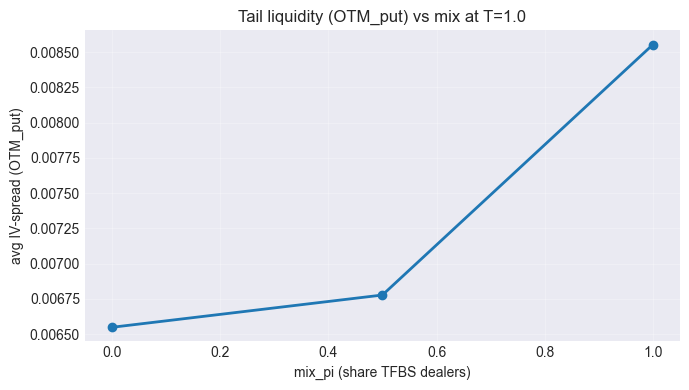

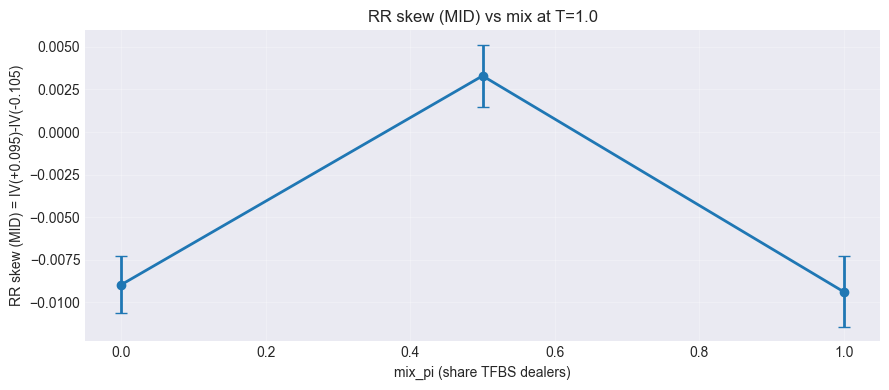

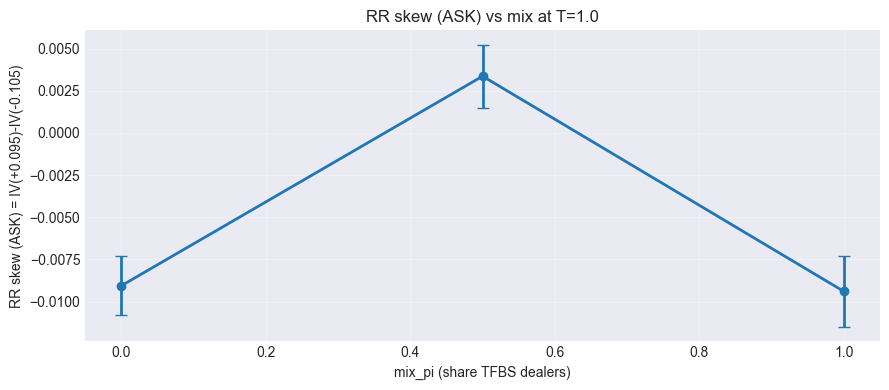

,T,bucket,anova_p_iv_spread_across_mix,anova_p_skew_across_mix
0,0.5,ATM,0.200452,NaN
1,0.5,OTM_put,0.000134,NaN
2,0.5,skew_ask_rr,NaN,0.006501
3,1.0,ATM,0.442382,NaN
4,1.0,OTM_put,0.000580,NaN
5,1.0,skew_ask_rr,NaN,0.000033
6,2.0,ATM,0.019235,NaN
7,2.0,OTM_put,0.000379,NaN
8,2.0,skew_ask_rr,NaN,0.584915


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.stats import f_oneway

from model import ABMModel
from market import LimitOrderBook
from analysis import bs_price_call, bs_price_put, fractional_price_call_mc, fractional_price_put_mc


def implied_vol_bs(price, S0, K, r, T, option_type):
    price = float(price); S0 = float(S0); K = float(K); r = float(r); T = float(T)
    if T <= 0 or S0 <= 0 or K <= 0 or not np.isfinite(price):
        return np.nan

    disc = float(np.exp(-r * T))
    if option_type == "call":
        lo = float(max(0.0, S0 - K * disc))
        hi = float(S0)
        f = lambda s: bs_price_call(S0, K, r, s, T) - price
    else:
        lo = float(max(0.0, K * disc - S0))
        hi = float(K * disc)
        f = lambda s: bs_price_put(S0, K, r, s, T) - price

    eps_b = float(1e-12 * max(1.0, hi))
    if price <= lo + eps_b:
        return 0.0
    if price >= hi - eps_b:
        return 5.0

    if price < lo:
        price = float(lo + eps_b)
    if price > hi:
        price = float(hi - eps_b)

    try:
        return float(brentq(f, 1e-6, 5.0, maxiter=200))
    except Exception:
        return np.nan


def bucket_from_m(m, option_type):
    m = float(m)
    if option_type == "put":
        if m < 0.90:
            return "OTM_put"
        if m > 1.10:
            return "ITM_put"
        return "ATM"
    else:
        if m < 0.90:
            return "ITM_call"
        if m > 1.10:
            return "OTM_call"
        return "ATM"


def estimate_sigma_from_model(m_abm, idx, dt, window):
    lr = np.array(m_abm.market.log_returns[:idx], dtype=float)
    lrw = lr[-int(window):] if lr.size > 0 else lr
    s = float(np.std(lrw) / np.sqrt(float(dt))) if lrw.size >= 2 else 0.05
    return float(max(1e-4, s))


def price_model(S0, K, r, sigma, T, option_type, is_tfbs, alpha_frac, n_mc, seed):
    if not is_tfbs:
        if option_type == "put":
            return float(bs_price_put(S0, K, r, sigma, T))
        return float(bs_price_call(S0, K, r, sigma, T))
    if option_type == "put":
        return float(fractional_price_put_mc(S0, K, r, sigma, T, alpha=alpha_frac, n_mc=int(n_mc), seed=int(seed)))
    return float(fractional_price_call_mc(S0, K, r, sigma, T, alpha=alpha_frac, n_mc=int(n_mc), seed=int(seed)))


def build_option_quotes_from_lob(
    S0,
    K,
    r,
    sigma,
    T,
    option_type,
    mix_pi,
    alpha_frac,
    n_mc,
    n_dealers,
    under_spread,
    under_depth,
    rng,
    tick_size=1e-4,
    base_halfspread_frac=0.02,
    k_liq=40.0,
    risk_wings=2.0,
    u_stress=None,
    under_regime=None,
):
    S0 = float(S0); K = float(K); r = float(r); sigma = float(sigma); T = float(T)
    mix_pi = float(mix_pi)
    under_spread = float(under_spread) if np.isfinite(under_spread) else 0.0
    under_depth = float(under_depth) if np.isfinite(under_depth) else 1.0
    under_depth = float(max(1.0, under_depth))

    if u_stress is None or not np.isfinite(float(u_stress)):
        u_stress = float(rng.uniform())
    else:
        u_stress = float(u_stress)

    if under_regime is None or not np.isfinite(float(under_regime)):
        under_regime = 0.0
    else:
        under_regime = float(under_regime)

    book = LimitOrderBook(tick_size=float(tick_size), rng=rng)

    n_tfbs = int(round(mix_pi * int(n_dealers)))
    is_tfbs_flags = np.array([1] * n_tfbs + [0] * (int(n_dealers) - n_tfbs), dtype=int)
    rng.shuffle(is_tfbs_flags)

    logm = float(np.log(max(1e-12, K / S0)))
    neg = float(max(-logm, 0.0))
    pos = float(max(logm, 0.0))
    if option_type == "put":
        wing_mult = float(1.0 + risk_wings * (1.8 * neg + 0.6 * pos))
        tail = float(neg)
    else:
        wing_mult = float(1.0 + risk_wings * (1.8 * pos + 0.6 * neg))
        tail = float(pos)

    liq = float((under_spread / max(S0, 1e-12)) * (1.0 + 5.0 / np.sqrt(under_depth)))
    liq_mult = float(1.0 + k_liq * liq)

    p_stress = (
        0.03
        + 0.55 * under_regime
        + 0.55 * mix_pi * (tail / (tail + 0.12))
        + 0.20 * (liq / (liq + 0.002))
    )
    p_stress = float(min(0.97, max(0.01, p_stress)))
    opt_regime = 1 if u_stress < p_stress else 0

    seed_tf = int(rng.integers(1, 2_000_000_000))
    seed_rn = int(rng.integers(1, 2_000_000_000))
    fv_rn = price_model(S0, K, r, sigma, T, option_type, False, alpha_frac, n_mc, seed_rn)
    fv_tf = price_model(S0, K, r, sigma, T, option_type, True,  alpha_frac, n_mc, seed_tf)

    disc = float(np.exp(-r * T))
    if option_type == "put":
        intrinsic = float(max(K * disc - S0, 0.0))
        eps_u = float(1e-12 * max(1.0, K * disc))
        upper = float(K * disc - eps_u)
    else:
        intrinsic = float(max(S0 - K * disc, 0.0))
        eps_u = float(1e-12 * max(1.0, S0))
        upper = float(S0 - eps_u)

    base_q = int(max(1, 5 // (1 + int(2 * abs(logm)))))

    bids_all = []
    asks_all = []

    for j in range(int(n_dealers)):
        is_tfbs = bool(is_tfbs_flags[j] == 1)

        fv = float(fv_tf if is_tfbs else fv_rn)
        fv = float(fv * (1.0 + 0.003 * float(rng.normal())))
        fv = float(max(fv, intrinsic + 1e-10))
        fv = float(min(fv, upper))

        extr = float(max(fv - intrinsic, 1e-10))

        half = float(base_halfspread_frac * wing_mult * liq_mult * extr)
        half = float(max(1e-8, half))

        q = int(base_q)

        if opt_regime == 1:
            half = float(half * (1.0 + 2.0 * tail + 0.7))
            q = int(max(1, round(q * 0.55)))

        if is_tfbs:
            half = float(half * (1.0 + 3.0 * tail + 1.0 * opt_regime))
            q = int(max(1, round(q * 0.55 / (1.0 + 4.5 * tail))))

        bid = float(intrinsic + max(1e-10, extr - half))
        ask = float(intrinsic + (extr + half))

        bid = float(min(bid, upper - 2e-10))
        ask = float(min(ask, upper))
        if ask <= bid:
            ask = float(min(upper, bid + 1e-10))
        if bid < intrinsic + 1e-10:
            bid = float(intrinsic + 1e-10)
            if ask <= bid:
                ask = float(min(upper, bid + 1e-10))

        bids_all.append(bid)
        asks_all.append(ask)

        book.add_limit(agent_id=j, side="buy", price=bid, qty=q, ttl=10_000)
        book.add_limit(agent_id=j, side="sell", price=ask, qty=q, ttl=10_000)

    bids_all = np.array(bids_all, dtype=float)
    asks_all = np.array(asks_all, dtype=float)

    bid = float(np.quantile(bids_all, 0.70))
    ask = float(np.quantile(asks_all, 0.30))

    if not np.isfinite(bid) or not np.isfinite(ask) or ask <= bid:
        bid = float(np.quantile(bids_all, 0.60))
        ask = float(np.quantile(asks_all, 0.40))

    if not np.isfinite(bid) or not np.isfinite(ask) or ask <= bid:
        bid = float(np.max(bids_all))
        ask = float(np.min(asks_all))

    if not np.isfinite(bid) or not np.isfinite(ask) or ask <= bid:
        return {"bid": np.nan, "ask": np.nan, "mid": np.nan, "spread": np.nan}

    mid = float(0.5 * (bid + ask))
    return {"bid": bid, "ask": ask, "mid": mid, "spread": float(ask - bid)}


def rr_at_targets(d, iv_col, left_target=-0.1053605, right_target=0.0953102):
    g = d.groupby("logm")[iv_col].mean().dropna()
    if g.empty:
        return np.nan
    xs = np.array(sorted(g.index.values), dtype=float)
    if xs.size < 2:
        return np.nan
    xL = xs[np.argmin(np.abs(xs - float(left_target)))]
    xR = xs[np.argmin(np.abs(xs - float(right_target)))]
    if not np.isfinite(xL) or not np.isfinite(xR):
        return np.nan
    yL = float(g.loc[xL])
    yR = float(g.loc[xR])
    return float(yR - yL)


def _style_ax(ax):
    ax.grid(True, alpha=0.25)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)


def plot_h4(df, skew, T_pick):
    T_pick = float(T_pick)

    d = df[df["T"] == T_pick].dropna(subset=["iv_mid", "logm"]).copy()
    fig, ax = plt.subplots(figsize=(9, 4))
    for mix_pi in sorted(d["mix_pi"].unique()):
        s = d[d["mix_pi"] == mix_pi].groupby("logm", as_index=False)["iv_mid"].mean().sort_values("logm")
        ax.plot(s["logm"].values, s["iv_mid"].values, marker="o", linewidth=2, label=f"mix_pi={mix_pi}")
    ax.set_xlabel("log(K/S0)")
    ax.set_ylabel("implied vol (mid)")
    ax.set_title(f"IV smile (MID) at T={T_pick}")
    ax.legend(frameon=False)
    _style_ax(ax)
    plt.tight_layout()
    plt.show()

    d2 = df[df["T"] == T_pick].dropna(subset=["iv_ask", "logm"]).copy()
    fig, ax = plt.subplots(figsize=(9, 4))
    for mix_pi in sorted(d2["mix_pi"].unique()):
        s = d2[d2["mix_pi"] == mix_pi].groupby("logm", as_index=False)["iv_ask"].mean().sort_values("logm")
        ax.plot(s["logm"].values, s["iv_ask"].values, marker="o", linewidth=2, label=f"mix_pi={mix_pi}")
    ax.set_xlabel("log(K/S0)")
    ax.set_ylabel("implied vol (ask)")
    ax.set_title(f"IV smile (ASK) at T={T_pick}")
    ax.legend(frameon=False)
    _style_ax(ax)
    plt.tight_layout()
    plt.show()

    g = df[df["T"] == T_pick].groupby(["mix_pi", "bucket"], as_index=False)["iv_spread"].mean()
    piv = g.pivot(index="bucket", columns="mix_pi", values="iv_spread")
    piv = piv.reindex(["ITM_put", "ATM", "OTM_put"])

    fig, ax = plt.subplots(figsize=(9, 4))
    piv.plot(kind="bar", ax=ax, width=0.8)
    ax.set_xlabel("bucket")
    ax.set_ylabel("avg IV-spread (iv_ask - iv_bid)")
    ax.set_title(f"Liquidity (IV-spread) by bucket at T={T_pick}")
    ax.legend(title="mix_pi", frameon=False)
    _style_ax(ax)
    plt.tight_layout()
    plt.show()

    tail = g[g["bucket"] == "OTM_put"].sort_values("mix_pi")
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(tail["mix_pi"].values, tail["iv_spread"].values, marker="o", linewidth=2)
    ax.set_xlabel("mix_pi (share TFBS dealers)")
    ax.set_ylabel("avg IV-spread (OTM_put)")
    ax.set_title(f"Tail liquidity (OTM_put) vs mix at T={T_pick}")
    _style_ax(ax)
    plt.tight_layout()
    plt.show()

    dsk = skew[skew["T"] == T_pick].copy()

    for col, title in [
        ("skew_mid_rr", "RR skew (MID)"),
        ("skew_ask_rr", "RR skew (ASK)"),
    ]:
        tmp = dsk.dropna(subset=[col]).copy()
        if tmp.empty:
            continue
        gsk = tmp.groupby("mix_pi")[col].agg(["mean", "std", "count"]).reset_index()
        sem = gsk["std"].values / np.sqrt(np.maximum(1, gsk["count"].values))

        fig, ax = plt.subplots(figsize=(9, 4))
        ax.errorbar(gsk["mix_pi"].values, gsk["mean"].values, yerr=sem, marker="o", linewidth=2, capsize=4)
        ax.set_xlabel("mix_pi (share TFBS dealers)")
        ax.set_ylabel(f"{title} = IV(+0.095)-IV(-0.105)")
        ax.set_title(f"{title} vs mix at T={T_pick}")
        _style_ax(ax)
        plt.tight_layout()
        plt.show()


def run_h4_mixed_dealers(
    cfg_base,
    r=0.0,
    option_type="put",
    alpha_frac=0.80,
    T_list=(0.5, 1.0, 2.0),
    moneyness_grid=(0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3),
    mix_list=(0.0, 0.5, 1.0),
    n_rep=12,
    seed0=1,
    window=50,
    n_dealers=25,
    n_mc=20000,
    base_halfspread_frac=0.02,
    k_liq=40.0,
    risk_wings=2.5,
    tick_size_opt=1e-4,
    T_pick=1.0,
):
    cfg_base = dict(cfg_base)
    dt = float(cfg_base["dt"])
    S0 = float(cfg_base["S0"])
    T_list = tuple(float(x) for x in T_list)
    moneyness_grid = tuple(float(x) for x in moneyness_grid)
    mix_list = tuple(float(x) for x in mix_list)

    rows = []
    skew_rows = []

    for rep in range(int(n_rep)):
        seed = int(seed0 + rep * 999)
        rng = np.random.default_rng(seed)

        m_abm = ABMModel(seed=seed, **cfg_base)
        m_abm.run()

        for T in T_list:
            idx = int(round(T / dt))
            idx = max(2, min(idx, len(m_abm.spread_log)))
            a = max(0, idx - int(window))
            b = idx

            under_sp = float(np.nanmean(np.array(m_abm.spread_log[a:b], dtype=float)))
            db = float(np.nanmean(np.array(m_abm.depth_bid_log[a:b], dtype=float)))
            da = float(np.nanmean(np.array(m_abm.depth_ask_log[a:b], dtype=float)))
            under_depth = float(max(1.0, 0.5 * (db + da)))

            under_reg = float(np.nanmean(np.array(m_abm.regime_log[a:b], dtype=float))) if len(m_abm.regime_log) else 0.0
            under_reg = float(min(1.0, max(0.0, under_reg)))

            sigma = float(estimate_sigma_from_model(m_abm, idx, dt, window))

            for m in moneyness_grid:
                u_stress = float(rng.uniform())

                for mix_pi in mix_list:
                    K = float(S0 * float(m))
                    logm = float(np.log(K / S0))
                    buck = bucket_from_m(m, option_type)

                    q = build_option_quotes_from_lob(
                        S0=S0, K=K, r=r, sigma=sigma, T=T,
                        option_type=option_type,
                        mix_pi=mix_pi,
                        alpha_frac=alpha_frac,
                        n_mc=n_mc,
                        n_dealers=n_dealers,
                        under_spread=under_sp,
                        under_depth=under_depth,
                        rng=rng,
                        tick_size=tick_size_opt,
                        base_halfspread_frac=base_halfspread_frac,
                        k_liq=k_liq,
                        risk_wings=risk_wings,
                        u_stress=u_stress,
                        under_regime=under_reg,
                    )

                    bid = float(q["bid"]); ask = float(q["ask"]); mid = float(q["mid"])

                    iv_mid = implied_vol_bs(mid, S0, K, r, T, option_type)
                    iv_bid = implied_vol_bs(bid, S0, K, r, T, option_type)
                    iv_ask = implied_vol_bs(ask, S0, K, r, T, option_type)
                    iv_spread = float(iv_ask - iv_bid) if (np.isfinite(iv_ask) and np.isfinite(iv_bid)) else np.nan

                    rows.append({
                        "rep": int(rep),
                        "T": float(T),
                        "mix_pi": float(mix_pi),
                        "m": float(m),
                        "K": float(K),
                        "logm": float(logm),
                        "bucket": buck,
                        "sigma": float(sigma),
                        "bid": bid,
                        "ask": ask,
                        "mid": mid,
                        "iv_mid": float(iv_mid) if np.isfinite(iv_mid) else np.nan,
                        "iv_bid": float(iv_bid) if np.isfinite(iv_bid) else np.nan,
                        "iv_ask": float(iv_ask) if np.isfinite(iv_ask) else np.nan,
                        "iv_spread": float(iv_spread) if np.isfinite(iv_spread) else np.nan,
                    })

    df = pd.DataFrame(rows)

    for rep in sorted(df["rep"].unique()):
        for mix_pi in sorted(df["mix_pi"].unique()):
            for T in sorted(df["T"].unique()):
                d = df[(df["rep"] == rep) & (df["mix_pi"] == mix_pi) & (df["T"] == T)].copy()
                d1 = d.dropna(subset=["iv_mid", "logm"])
                d2 = d.dropna(subset=["iv_ask", "logm"])
                skew_mid = rr_at_targets(d1, "iv_mid")
                skew_ask = rr_at_targets(d2, "iv_ask")
                skew_rows.append({
                    "rep": int(rep),
                    "mix_pi": float(mix_pi),
                    "T": float(T),
                    "skew_mid_rr": skew_mid,
                    "skew_ask_rr": skew_ask,
                })

    skew = pd.DataFrame(skew_rows)

    plot_h4(df, skew, T_pick=T_pick)

    stats_rows = []
    for T in sorted(df["T"].unique()):
        dT = df[df["T"] == T].copy()
        for buck in sorted(dT["bucket"].unique()):
            if buck == "ITM_put":
                continue
            groups = []
            ok = True
            for mix_pi in sorted(dT["mix_pi"].unique()):
                x = dT[(dT["mix_pi"] == mix_pi) & (dT["bucket"] == buck)]["iv_spread"].dropna().values
                if len(x) < 2:
                    ok = False
                groups.append(x)
            p = float(f_oneway(*groups).pvalue) if ok else np.nan
            stats_rows.append({"T": float(T), "bucket": buck, "anova_p_iv_spread_across_mix": p})

        groups = []
        ok = True
        for mix_pi in sorted(skew["mix_pi"].unique()):
            x = skew[(skew["T"] == T) & (skew["mix_pi"] == mix_pi)]["skew_ask_rr"].dropna().values
            if len(x) < 2:
                ok = False
            groups.append(x)
        p_sk = float(f_oneway(*groups).pvalue) if ok else np.nan
        stats_rows.append({"T": float(T), "bucket": "skew_ask_rr", "anova_p_skew_across_mix": p_sk})

    stats = pd.DataFrame(stats_rows)
    return df, skew, stats


df_h4, skew_h4, stats_h4 = run_h4_mixed_dealers(
    cfg_base=cfg,
    r=0.0,
    option_type="put",
    alpha_frac=0.80,
    T_list=(0.5, 1.0, 2.0),
    moneyness_grid=(0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3),
    mix_list=(0.0, 0.5, 1.0),
    n_rep=12,
    n_dealers=25,
    n_mc=20000,
    base_halfspread_frac=0.02,
    k_liq=40.0,
    risk_wings=2.5,
    tick_size_opt=1e-4,
    T_pick=1.0,
)

stats_h4


In [ ]:
alphas = [0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
out = []
for a in alphas:
    _, _, s = run_h1_pricing_experiment(
        cfg=cfg, dt=dt, steps=steps, r=r, K_grid=K_grid,
        option_type="put", alpha_frac=a,
        n_paths=200, n_mc=40000, n_rep=10, seed0=1
    )
    out.append((a, s["mean_abs_err_bs"], s["mean_abs_err_frac"]))
out


t=200  bb=102.30  ba=103.00  sp=0.700  db=4.00  da=7.00  trades_step=19
t=200  bb=102.40  ba=102.80  sp=0.400  db=59.00  da=51.00  trades_step=2
t=200  bb=109.20  ba=109.40  sp=0.200  db=30.00  da=2.00  trades_step=1
t=200  bb=98.00  ba=98.40  sp=0.400  db=56.00  da=56.00  trades_step=0
t=200  bb=101.70  ba=102.00  sp=0.300  db=15.00  da=21.00  trades_step=31
t=200  bb=105.60  ba=105.90  sp=0.300  db=15.00  da=44.00  trades_step=25
t=200  bb=98.70  ba=99.10  sp=0.400  db=60.00  da=59.00  trades_step=19
t=200  bb=87.80  ba=88.10  sp=0.300  db=20.00  da=14.00  trades_step=21
t=200  bb=98.60  ba=99.30  sp=0.700  db=6.00  da=4.00  trades_step=18
t=200  bb=113.80  ba=114.50  sp=0.700  db=7.00  da=4.00  trades_step=18
t=200  bb=100.80  ba=101.60  sp=0.800  db=6.00  da=20.00  trades_step=17
t=200  bb=95.90  ba=96.30  sp=0.400  db=60.00  da=60.00  trades_step=21
t=200  bb=98.20  ba=98.60  sp=0.400  db=59.00  da=60.00  trades_step=1
t=200  bb=106.40  ba=106.80  sp=0.400  db=59.00  da=58.00  tra

[(0.2, 0.49085524957986787, 0.3263162349750387),
 (0.3, 0.49085524957986787, 0.29920470341529626),
 (0.5, 0.49085524957986787, 0.28423672105580067),
 (0.6, 0.49085524957986787, 0.29550804047654616),
 (0.7, 0.49085524957986787, 0.32159610418631673),
 (0.8, 0.49085524957986787, 0.36467813448895503),
 (0.9, 0.49085524957986787, 0.42157290412049075)]

In [4]:
import numpy as np
import pandas as pd
from analysis import bs_price_call, bs_price_put, bs_delta_call, bs_delta_put, reference_price_call, fractional_price_call_mc, reference_price_put, fractional_price_put_mc, run_abm_paths, estimate_sigma


import numpy as np
import pandas as pd

def run_h3_tfbs_gains_surface(
    cfg_base,
    steps_grid,
    moneyness_grid,
    r,
    alpha_frac=0.85,
    n_paths=300,
    n_mc=40_000,
    n_rep=10,
    seed0=1,
    option_type="put",
):
    rows = []
    S0 = float(cfg_base["S0"])
    dt = float(cfg_base["dt"])

    for rep in range(int(n_rep)):
        rep_seed = int(seed0 + rep * 999)

        for steps in steps_grid:
            steps = int(steps)
            cfg = dict(cfg_base)
            cfg["steps"] = steps

            paths = run_abm_paths(cfg, n_paths=int(n_paths), seed0=rep_seed)
            sigma = float(estimate_sigma(paths, dt=dt))
            T = float(steps) * dt

            for m in moneyness_grid:
                m = float(m)
                K = float(S0 * m)

                if option_type == "call":
                    ref = float(reference_price_call(paths, K=K, r=r, T=T))
                    p_bs = float(bs_price_call(S0, K, r, sigma, T))
                    p_fr = float(fractional_price_call_mc(S0, K, r, sigma, T, alpha=alpha_frac, n_mc=n_mc, seed=rep_seed + int(1e6*m) + steps))
                else:
                    ref = float(reference_price_put(paths, K=K, r=r, T=T))
                    p_bs = float(bs_price_put(S0, K, r, sigma, T))
                    p_fr = float(fractional_price_put_mc(S0, K, r, sigma, T, alpha=alpha_frac, n_mc=n_mc, seed=rep_seed + int(1e6*m) + steps))

                e_bs = abs(p_bs - ref)
                e_fr = abs(p_fr - ref)
                imp = float(e_bs - e_fr)

                rows.append({
                    "rep": int(rep),
                    "steps": int(steps),
                    "T": float(T),
                    "m": float(m),
                    "abs_log_m": float(abs(np.log(m))),
                    "K": float(K),
                    "sigma": float(sigma),
                    "ref": float(ref),
                    "bs": float(p_bs),
                    "frac": float(p_fr),
                    "abs_err_bs": float(e_bs),
                    "abs_err_frac": float(e_fr),
                    "improvement": float(imp),
                })

    return pd.DataFrame(rows)

def summarize_h3_tfbs(df, n_T_bins=4, n_m_bins=6):
    d = df.copy()
    d["T_bin"] = pd.qcut(d["T"], q=int(n_T_bins), duplicates="drop")
    d["m_bin"] = pd.qcut(d["abs_log_m"], q=int(n_m_bins), duplicates="drop")

    surf = (
        d.groupby(["T_bin", "m_bin"])["improvement"]
        .agg(["mean", "median", "count", lambda x: float(np.mean(np.array(x) > 0.0))])
        .reset_index()
    )
    surf = surf.rename(columns={"<lambda_0>": "share_improvement_pos"})

    byT = d.groupby("T")["improvement"].agg(["mean", "median", "count"]).reset_index()
    byM = d.groupby("abs_log_m")["improvement"].agg(["mean", "median", "count"]).reset_index()

    top = d.sort_values("improvement", ascending=False).head(15)[["rep", "T", "m", "K", "improvement", "abs_err_bs", "abs_err_frac"]]
    bot = d.sort_values("improvement", ascending=True).head(15)[["rep", "T", "m", "K", "improvement", "abs_err_bs", "abs_err_frac"]]

    return surf, byT, byM, top, bot

def h3_regression_simple(df):
    X = np.column_stack([
        np.ones(len(df)),
        df["abs_log_m"].values,
        df["T"].values,
        (df["abs_log_m"].values * df["T"].values),
    ])
    y = df["improvement"].values
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = X @ beta
    resid = y - yhat
    n, k = X.shape
    s2 = float((resid @ resid) / max(1, n - k))
    XtX_inv = np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(s2 * XtX_inv))

    out = {
        "beta_intercept": float(beta[0]),
        "beta_abs_log_m": float(beta[1]),
        "beta_T": float(beta[2]),
        "beta_interaction_abs_log_m_x_T": float(beta[3]),
        "se_intercept": float(se[0]),
        "se_abs_log_m": float(se[1]),
        "se_T": float(se[2]),
        "se_interaction": float(se[3]),
    }
    return out


steps_grid = [100, 200, 400, 800]
moneyness_grid = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

df_h3 = run_h3_tfbs_gains_surface(
    cfg_base=cfg,
    steps_grid=steps_grid,
    moneyness_grid=moneyness_grid,
    r=0.0,
    alpha_frac=0.85,
    n_paths=300,
    n_mc=40_000,
    n_rep=10,
    seed0=1,
    option_type="put",
)

surf, byT, byM, top, bot = summarize_h3_tfbs(df_h3, n_T_bins=4, n_m_bins=6)
reg = h3_regression_simple(df_h3)

surf, reg


t=200  bb=102.30  ba=103.00  sp=0.700  db=4.00  da=7.00  trades_step=19
t=200  bb=102.40  ba=102.80  sp=0.400  db=59.00  da=51.00  trades_step=2
t=200  bb=109.20  ba=109.40  sp=0.200  db=30.00  da=2.00  trades_step=1
t=200  bb=98.00  ba=98.40  sp=0.400  db=56.00  da=56.00  trades_step=0
t=200  bb=101.70  ba=102.00  sp=0.300  db=15.00  da=21.00  trades_step=31
t=200  bb=105.60  ba=105.90  sp=0.300  db=15.00  da=44.00  trades_step=25
t=200  bb=98.70  ba=99.10  sp=0.400  db=60.00  da=59.00  trades_step=19
t=200  bb=87.80  ba=88.10  sp=0.300  db=20.00  da=14.00  trades_step=21
t=200  bb=98.60  ba=99.30  sp=0.700  db=6.00  da=4.00  trades_step=18
t=200  bb=113.80  ba=114.50  sp=0.700  db=7.00  da=4.00  trades_step=18
t=200  bb=100.80  ba=101.60  sp=0.800  db=6.00  da=20.00  trades_step=17
t=200  bb=95.90  ba=96.30  sp=0.400  db=60.00  da=60.00  trades_step=21
t=200  bb=98.20  ba=98.60  sp=0.400  db=59.00  da=60.00  trades_step=1
t=200  bb=106.40  ba=106.80  sp=0.400  db=59.00  da=58.00  tra

/var/folders/bk/4050dzqs6h34d9ym13s8wf7r0000gn/T/ipykernel_50628/873934636.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d.groupby(["T_bin", "m_bin"])["improvement"]


(             T_bin             m_bin      mean        median  count  \
 0   (0.396, 0.694]  (-0.001, 0.0953] -0.102504 -1.286018e-01     20   
 1   (0.396, 0.694]   (0.0953, 0.105]  0.004826  6.564312e-03     10   
 2   (0.396, 0.694]    (0.105, 0.182] -0.001533 -3.450607e-03     10   
 3   (0.396, 0.694]    (0.182, 0.223] -0.000308 -2.766478e-04     10   
 4   (0.396, 0.694]    (0.223, 0.262] -0.009216  7.780171e-04     10   
 5   (0.396, 0.694]    (0.262, 0.357] -0.000005  4.845641e-21     10   
 6    (0.694, 1.19]  (-0.001, 0.0953]  0.132538  1.530189e-01     20   
 7    (0.694, 1.19]   (0.0953, 0.105]  0.087021  8.803265e-02     10   
 8    (0.694, 1.19]    (0.105, 0.182]  0.013250  1.804782e-02     10   
 9    (0.694, 1.19]    (0.182, 0.223]  0.003630  3.682548e-03     10   
 10   (0.694, 1.19]    (0.223, 0.262] -0.000632  1.211697e-05     10   
 11   (0.694, 1.19]    (0.262, 0.357] -0.000096 -2.049391e-05     10   
 12   (1.19, 1.984]  (-0.001, 0.0953]  0.130186  1.232636e-01   

In [ ]:
# === demo H2: transaction costs and hedging errors ===

import numpy as np
import pandas as pd
from scipy.stats import norm

def _option_payoff(ST, K, option_type):
    ST = float(ST); K = float(K)
    if option_type == "call":
        return float(max(ST - K, 0.0))
    return float(max(K - ST, 0.0))

def hedge_errors_delta_bs(paths, K, r, dt, sigma, option_type, tc_rate, tc_fixed, rebalance_every):
    paths = np.asarray(paths, dtype=float)
    n_paths, n_steps_plus1 = paths.shape
    steps = n_steps_plus1 - 1
    T = float(steps) * float(dt)

    if option_type == "call":
        prem0 = bs_price_call(paths[0, 0], K, r, sigma, T)
        delta_fn = bs_delta_call
    else:
        prem0 = bs_price_put(paths[0, 0], K, r, sigma, T)
        delta_fn = bs_delta_put

    errs = np.empty(n_paths, dtype=float)

    for p in range(n_paths):
        S0 = float(paths[p, 0])
        delta = float(delta_fn(S0, K, r, sigma, T))
        cash = float(prem0 - delta * S0)

        for i in range(steps):
            Si = float(paths[p, i])
            cash *= float(np.exp(float(r) * float(dt)))

            do_reb = (i % int(rebalance_every) == 0)
            if do_reb:
                tau = float(max(0.0, T - float(i) * float(dt)))
                new_delta = float(delta_fn(Si, K, r, sigma, tau))
                dq = float(new_delta - delta)
                if dq != 0.0:
                    tc = float(tc_rate) * abs(dq) * Si + (float(tc_fixed) if abs(dq) > 0.0 else 0.0)
                    cash -= float(dq * Si + tc)
                    delta = new_delta

        ST = float(paths[p, -1])
        port = float(cash + delta * ST)
        payoff = float(_option_payoff(ST, K, option_type))
        errs[p] = float(port - payoff)

    return errs

def cvar(losses, q=0.99):
    x = np.asarray(losses, dtype=float)
    if x.size == 0:
        return float("nan")
    v = float(np.quantile(x, q))
    tail = x[x >= v]
    return float(np.mean(tail)) if tail.size else float(v)

def run_h2_transaction_costs_experiment(
    cfg,
    dt,
    steps,
    r,
    K,
    tc_grid,
    n_paths=300,
    seed0=1,
    option_type="put",
    rebalance_fast=1,
    rebalance_slow=10,
    tc_fixed=0.0,
):
    paths = run_abm_paths(cfg, n_paths=int(n_paths), seed0=int(seed0))
    sigma = estimate_sigma(paths, dt=float(dt))

    rows = []
    for tc_rate in tc_grid:
        tc_rate = float(tc_rate)

        e_fast = hedge_errors_delta_bs(
            paths=paths, K=K, r=r, dt=dt, sigma=sigma, option_type=option_type,
            tc_rate=tc_rate, tc_fixed=tc_fixed, rebalance_every=rebalance_fast
        )
        e_slow = hedge_errors_delta_bs(
            paths=paths, K=K, r=r, dt=dt, sigma=sigma, option_type=option_type,
            tc_rate=tc_rate, tc_fixed=tc_fixed, rebalance_every=rebalance_slow
        )

        loss_fast = -e_fast
        loss_slow = -e_slow

        rows.append({
            "tc_rate": tc_rate,
            "sigma": float(sigma),
            "strategy": f"delta_bs_reb{rebalance_fast}",
            "mean_abs_error": float(np.mean(np.abs(e_fast))),
            "mean_loss": float(np.mean(loss_fast)),
            "cvar99_loss": float(cvar(loss_fast, 0.99)),
        })
        rows.append({
            "tc_rate": tc_rate,
            "sigma": float(sigma),
            "strategy": f"delta_bs_reb{rebalance_slow}",
            "mean_abs_error": float(np.mean(np.abs(e_slow))),
            "mean_loss": float(np.mean(loss_slow)),
            "cvar99_loss": float(cvar(loss_slow, 0.99)),
        })

    df = pd.DataFrame(rows)

    wide_abs = df.pivot(index="tc_rate", columns="strategy", values="mean_abs_error").reset_index()
    wide_cvar = df.pivot(index="tc_rate", columns="strategy", values="cvar99_loss").reset_index()

    fast_name = f"delta_bs_reb{rebalance_fast}"
    slow_name = f"delta_bs_reb{rebalance_slow}"

    df_gap = pd.DataFrame({
        "tc_rate": wide_abs["tc_rate"].values,
        "gap_mean_abs_error_fast_minus_slow": (wide_abs[fast_name] - wide_abs[slow_name]).values,
        "gap_cvar99_loss_fast_minus_slow": (wide_cvar[fast_name] - wide_cvar[slow_name]).values,
    })

    return df, df_gap

# пример запуска 
tc_grid = [0.0, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3]
df, df_gap = run_h2_transaction_costs_experiment(cfg, dt=cfg["dt"], steps=cfg["steps"], r=0.0, K=cfg["S0"], tc_grid=tc_grid)
display(df_gap)


t=200  bb=102.30  ba=103.00  sp=0.700  db=4.00  da=7.00  trades_step=19
t=200  bb=102.40  ba=102.80  sp=0.400  db=59.00  da=51.00  trades_step=2
t=200  bb=109.20  ba=109.40  sp=0.200  db=30.00  da=2.00  trades_step=1
t=200  bb=98.00  ba=98.40  sp=0.400  db=56.00  da=56.00  trades_step=0
t=200  bb=101.70  ba=102.00  sp=0.300  db=15.00  da=21.00  trades_step=31
t=200  bb=105.60  ba=105.90  sp=0.300  db=15.00  da=44.00  trades_step=25
t=200  bb=98.70  ba=99.10  sp=0.400  db=60.00  da=59.00  trades_step=19
t=200  bb=87.80  ba=88.10  sp=0.300  db=20.00  da=14.00  trades_step=21
t=200  bb=98.60  ba=99.30  sp=0.700  db=6.00  da=4.00  trades_step=18
t=200  bb=113.80  ba=114.50  sp=0.700  db=7.00  da=4.00  trades_step=18
t=200  bb=100.80  ba=101.60  sp=0.800  db=6.00  da=20.00  trades_step=17
t=200  bb=95.90  ba=96.30  sp=0.400  db=60.00  da=60.00  trades_step=21
t=200  bb=98.20  ba=98.60  sp=0.400  db=59.00  da=60.00  trades_step=1
t=200  bb=106.40  ba=106.80  sp=0.400  db=59.00  da=58.00  tra

,tc_rate,gap_mean_abs_error_fast_minus_slow,gap_cvar99_loss_fast_minus_slow
0,0.0000,-0.624850,0.960732
1,0.0001,-0.618179,1.035630
2,0.0002,-0.607237,1.110528
3,0.0005,-0.549874,1.354375
4,0.0010,-0.383595,1.762298
5,0.0020,0.089225,2.544016


In [ ]:
from analysis import run_abm_paths, estimate_sigma
paths = run_abm_paths(cfg, n_paths=50, seed0=1)
sigma = estimate_sigma(paths, dt=cfg["dt"])
sigma


t=200  bb=102.30  ba=103.00  sp=0.700  db=4.00  da=7.00  trades_step=19
t=200  bb=102.40  ba=102.80  sp=0.400  db=59.00  da=51.00  trades_step=2
t=200  bb=109.20  ba=109.40  sp=0.200  db=30.00  da=2.00  trades_step=1
t=200  bb=98.00  ba=98.40  sp=0.400  db=56.00  da=56.00  trades_step=0
t=200  bb=101.70  ba=102.00  sp=0.300  db=15.00  da=21.00  trades_step=31
t=200  bb=105.60  ba=105.90  sp=0.300  db=15.00  da=44.00  trades_step=25
t=200  bb=98.70  ba=99.10  sp=0.400  db=60.00  da=59.00  trades_step=19
t=200  bb=87.80  ba=88.10  sp=0.300  db=20.00  da=14.00  trades_step=21
t=200  bb=98.60  ba=99.30  sp=0.700  db=6.00  da=4.00  trades_step=18
t=200  bb=113.80  ba=114.50  sp=0.700  db=7.00  da=4.00  trades_step=18
t=200  bb=100.80  ba=101.60  sp=0.800  db=6.00  da=20.00  trades_step=17
t=200  bb=95.90  ba=96.30  sp=0.400  db=60.00  da=60.00  trades_step=21
t=200  bb=98.20  ba=98.60  sp=0.400  db=59.00  da=60.00  trades_step=1
t=200  bb=106.40  ba=106.80  sp=0.400  db=59.00  da=58.00  tra

0.06563414534413115

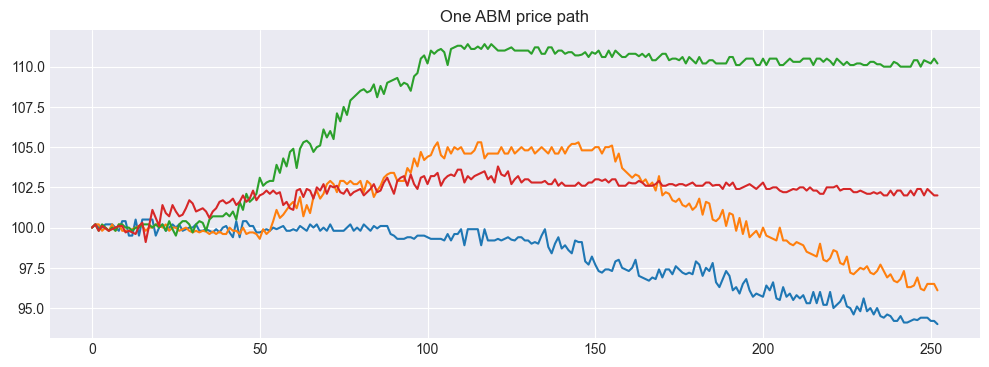

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(paths[11])
plt.plot(paths[21])
plt.plot(paths[34])
plt.plot(paths[1])
plt.title("One ABM price path")
plt.show()


In [ ]:
from visualization import plot_market_dashboard

plot_market_dashboard(cfg, paths[0], dt=cfg["dt"])

TypeError: plot_market_dashboard() got an unexpected keyword argument 'dt'